In [1]:
import numpy as np
import copy
import plotly.graph_objects as go
import time
import matplotlib.pyplot as plt
from numpy import random
from numba import jit
import copy

In [2]:
def gen_random_conf(n):
    #input: n = length of array = width of array
    #output: random 10x10 array (-1/2's and +1/2's)
    
    A = np.random.choice([-0.5,0.5], size=(n,n))
    
    return(A)

In [3]:
#Compute energy as a function of J (i.e. assume J = 1)
# This is inefficient but I think easier to understand 
# Loop over all spins
@jit(nopython=True)
def calculate_energy(spin):
    
    spin_shape = spin.shape
    
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
        #quit()
        
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
        
        energy = 0
        #get_ising_plot_1(array = spin);

        for i in range(N):  # 0, N-1
          for j in range(N): # 0, N-1
            # calculate four interactions
            for delta_i in range(-1,2,2):  # -1 and 1
              ii = i + delta_i
              if (ii < 0): 
                ii = ii + N
              if (ii >=N): 
                ii = ii - N
              energy = energy - spin[i,j]*spin[ii, j] #spin--> array name

            for delta_j in range(-1,2,2):  # -1 and 1
              jj = j + delta_j
              if (jj < 0): 
                jj = jj + N
              if (jj >=N): 
                jj = jj - N
              energy = energy - spin[i,j]*spin[i, jj] 

            energy = energy * 0.5
    

    return energy

In [4]:
def magnetism_sum(spin):
    magnetism = np.sum(spin)
    return magnetism

## Metropolis-Hastings code
Generally we want to follow this Monte Carlo algorithm to determine how the Ising array changes over time
1. Start with some given Ising array
2. Propose a random change of spin
3. Calculate the energy of the new configuration
4. Determine if change is accepted
    - if change lowers energy, accept it
    - if change raises energy, accept it *with some given probability*

There's a few different methods we can use to calculate this probability
### Statistical mechanics
Using *statistical mechanics*, the probability of finding a given state is given by
$$ P = \frac{e^{-\beta H}}{Z} $$
Where $\beta = \frac{1}{k_bT}$ and $Z$ is the **partition function**, given by 
$$ Z = \sum_{states}e^{-\beta H} $$
However, this requires calculating energies of *all of the given states*, which scales as $2^{n_{spins}}$. 

This is pretty inefficient (i.e. for a 16x16 grid, $2^{16*16}\approx n_{\text{atoms in universe}}$)

### Approximating the partition function
A more reasonable approach is to randomly sample states and approximate an *average* energy of all states $\bar{E}$, which is then used to calculate $Z$ 

$$ Z = n_{states}*\bar{E}$$

However, even this is flawed as there are more low-energy states than high-energy ones. For example, consider a randomly shuffled deck of cards. If 'disorder' is lower energy, there's many more 'disordered' configurations of the deck than 'ordered.' This makes it harder to calculate a true average

### Metropolis-Hastings algorithm

Instead of requiring us to calculate the partition function to evaluate probability, the *Metropolis-Hastings algorithm* allows us to compare **relative likelihoods** of the new and old configurations

For example, say we propose a randomly flipped spin. We can write expressions for the probability of each configuration
$$ P_{before} = \frac{e^{-\beta H_{before}}}{Z} \quad  P_{after} = \frac{e^{-\beta H_{after}}}{Z} $$

If we instead look at the relative likelihood, the difficult-to-compute partition function vanishes
$$P = \frac{P_{after}}{P_{before}} = \frac{e^{-\beta H_{after}}/Z}{e^{-\beta H_{before}}/Z} = \frac{e^{-\beta H_{after}}}{e^{-\beta H_{before}}} \quad \text{where }0<P<1$$

This solves the difficult problem of calculating the partition function by only requiring that we know a function *proportional* to the probability density, without the need for normalization

In [ ]:
def metropolis(N, spin):
    k = 8.617E-5 #boltzman constant (eV/K)
    T = 300 #K
    beta = 1/(k*T)
    
    original_energy = calculate_energy(10, spin)
    
    #get_ising_plot_1(spin);
    
    # TODO: use your calculate_energy function for the new configuration
    new_energy = 0
    
    a = np.random.randint(0, N) 
    b = np.random.randint(0, N)
    random =  spin[a, b]

        #recalculate energy a
        
    delta = spin[(a+1)%N,b] + spin[a,(b+1)%N] + spin[(a-1)%N,b] + spin[a,(b-1)%N]

    new_energy = random*delta*2
    
    #This uses metropolis hastings method as described above
    if new_energy < 0:
        random *= -1
    elif np.random.rand() < np.exp(-new_energy*beta):
        random *= -1
                         
    # ABOVE: modify for Metropolis-Hastings relative likelihoods
    #if new system has higher energy, spin accepted with given probability 
    
    spin[a, b] = random

    #get_ising_plot_1(spin);

    return spin

##### Generate a plotly image from an array of spins 0.5 and -0.5 (Kat)
def get_ising_plot(spin):
    img = np.array(spin, dtype = object)
    for i in range(len(spin[0])):
        for j in range(len(spin[1])):
            if spin[i,j] == 0.5:
                img[i,j] = [255,255,255]
            else:
                img[i,j] = [0,0,0]
    image = go.Image(z=img)
    return image

# Stich together plotly frames to create an animation (Kat)
def get_ising_video(frames, initial_spin):
    fig = go.Figure(
    data=[get_ising_plot(initial_spin)], 
    layout=go.Layout(
        title = "Ising model demonstration",
        xaxis = {'showticklabels':False},
        yaxis = {'showticklabels':False},
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, dict(frame=dict(duration=20))])])]
        ), frames=frames )

    return fig                         

### 

In [ ]:
# Test Ava's Metropolis algorithm with video of Ising plot
N = 20 # size of Ising array
n = 10000 # number of Metropolis iterations
spin = gen_random_conf(N) # initial Ising array
initial_spin = spin
frames = []

for i in range(n):    
    spin = copy.deepcopy(metropolis(N,spin))
    frame = go.Frame(data = get_ising_plot(spin))
    frames.append(frame)    
    
fig = get_ising_video(frames, initial_spin)
fig.show()

## Timing Tests

In [ ]:
def iteration_time(it):
    start_time_tot = time.time()
    for i in range(it):
        spin = gen_random_conf(10)
        start_time_it = time.time()
        metropolis(10, spin)
        end_time_it = time.time()

        #print("Iteration " + str(i) + ": " + str(end_time_it - start_time_it))

    end_time_tot = time.time();   
    print("It took " + str(end_time_tot-start_time_tot) + " seconds total to run " + str(it) + " iterations.")

iteration_time(10000)


In [ ]:
def time_it():
    spin = gen_random_conf(10)
    start_time_it = time.time()
    metropolis(10, spin)
    end_time_it = time.time()
    return end_time_it - start_time_it


In [ ]:
plt.ylabel("Duration (sec)")
plt.xlabel("Number of Iterations")
duration_array = []
iteration_array = []
for i in range(100):
    duration_array.append(time_it())
    iteration_array.append(i+1)


#print(duration_array)
#print(iteration_array)
plt.plot(iteration_array, duration_array)


# Ploting Temperature/Magnetization

In [5]:
#New metro function that uses beta as an input
def metro(beta, spin):
    
    spin_shape = spin.shape
    
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
        quit()
        
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
    
    original_energy = calculate_energy(spin)
    
    new_spin = copy.deepcopy(spin)
    
    a = np.random.randint(0, N)
    b = np.random.randint(0, N)
    random =  spin[a, b]
    
    new_spin[a,b] *= -1
    
    new_energy = calculate_energy(new_spin)
    
    delta = new_energy - original_energy
    
    #for calculating local energy
    #before_flip = spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random
    
    #temp_random = random*-1
    
    #after_flip = spin[(a+1)%N,b]*random + spin[a,(b+1)%N]*random + spin[(a-1)%N,b]*random + spin[a,(b-1)%N]*random
    
    #delta = after_flip - before_flip
    chance = np.random.rand()
    
    if delta < 0:
        final_spin = new_spin
    elif chance <= np.exp(-new_energy*beta):
        final_spin = new_spin
    elif chance >np.exp(-new_energy*beta):
        final_spin = spin
        
    
    return final_spin

metro(1,gen_random_conf(10))


array([[ 0.5, -0.5, -0.5,  0.5, -0.5, -0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5, -0.5,  0.5, -0.5, -0.5, -0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5, -0.5],
       [-0.5,  0.5, -0.5, -0.5, -0.5, -0.5, -0.5,  0.5, -0.5, -0.5],
       [-0.5,  0.5,  0.5, -0.5,  0.5, -0.5, -0.5, -0.5,  0.5,  0.5],
       [ 0.5,  0.5, -0.5,  0.5, -0.5, -0.5,  0.5,  0.5,  0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5, -0.5, -0.5,  0.5, -0.5, -0.5, -0.5],
       [-0.5,  0.5, -0.5,  0.5,  0.5,  0.5,  0.5, -0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5,  0.5, -0.5,  0.5, -0.5,  0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5,  0.5, -0.5,  0.5,  0.5,  0.5,  0.5,  0.5]])

In [15]:
#Parameters
temp_point = 1000         #  number of temperature points
N = 10         #  size of the lattice, N x N
iterations = 1000       #  number of MC sweeps for equilibration
T  = np.linspace(1, 1000, temp_point); 
M = np.zeros(temp_point)

In [20]:
#Main code
spin = gen_random_conf(N)         
for x in range(temp_point):        # initialize
    new_beta=1.0/T[x]
    
    for i in range(iterations):         # equilibrate
        spin = metro(new_beta, spin)           # Monte Carlo moves    
    mag = magnetism_sum(spin)        # calculate the magnetisation

    # divide by number of sites and iteractions to obtain intensive values    
    M[x] = (1/(N**2))*mag

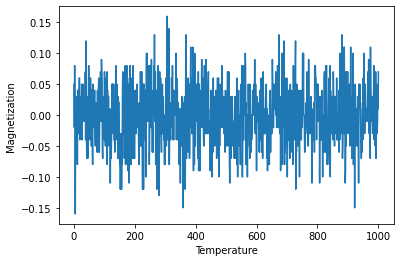

In [21]:
plt.plot(T, M)
plt.xlabel("Temperature"); 
plt.ylabel("Magnetization ");